In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
#import tensorflow as tf
import keras
from keras.utils import multi_gpu_model
import tensorflow as tf
from temnn.knet import net
#from temdata.dataset import DataEntry,DataSet
from temnn.net.dataset import DataEntry,DataSet
from temnn.net.mods import local_normalize
from pyqstem.imaging import CTF
import matplotlib.pyplot as plt
# Peak detection
from stm.preprocess import normalize
from stm.feature.peaks import find_local_peaks, refine_peaks
from skimage.morphology import disk
from scipy.spatial import cKDTree as KDTree
import sys
import os
from collections import deque
from multiprocessing import Pool
import numpy as np
import hyperspy.api as hs

In [3]:

graph_dir = 'graphs-mos2-defocus-classes-5-positive'
graph_path = os.path.join(graph_dir, 'clusters-{:d}.h5')


In [4]:
# Microscope parameters
#sampling=0.11953 #244.8/2048
sampling=0.2275
Cs=-10e4
defocus=90
focal_spread=30
blur=1.5
#dose=5*10**2
dose = 2e4
mtf_param=[1,0,4.89683027e-01,2.34644273e+00]

In [5]:
num_gpus = 1
batch_size = 8 * num_gpus

In [6]:
def load(data_dir):
    "Load data folder."
    #models=sorted(glob(data_dir+"model/model_*.cfg"))
    waves=sorted(glob(data_dir+"wave/wave_*.npz"))
    #labels=sorted(glob(data_dir+"label/label_*.npy"))
    points=sorted(glob(data_dir+"points/points_*.npz"))
    #entries=[DataEntry(model,wave,label) for model,wave,label in zip(models,waves,labels)]
    entries = [DataEntry(wave=w, points=p) for w,p in zip(waves,points)]

    return DataSet(entries)

In [7]:
def load_CNN(graph_path, size, num_gpus=1):
    "Load the Keras neural net, and return a Model."
    kernel_num=32

    if num_gpus == 1:
        x = keras.Input(shape=size+(image_features,))
        model = net.graph(x, output_features=num_classes+1)
        model.load_weights(graph_path) #Bliver ved med at crashe lige her
    else:
        with tf.device('/cpu:0'):
            x = keras.Input(shape=size+(image_features,))
            model = net.graph(x, output_features=num_classes+1)
            model.load_weights(graph_path)
        model = multi_gpu_model(model, gpus=num_gpus)

    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    
    return (x, model)

In [8]:
def makeimage(entry, size):

    image = np.zeros((1, size[0], size[1], image_features ))
    spotsize = 0.4 
    entry.load()    
        
    for i in range(image_features):
        #CTF er contrast transfer funktion, få den til at loope over defucus, ligger defocus til billedet
        ctf=CTF(defocus=defocus+i*deltafocus,Cs=Cs,focal_spread=focal_spread)

        entry.create_image(ctf,sampling,blur,dose,mtf_param,concatenate=(i>0))

    entry.create_label(sampling, width = int(spotsize/sampling), num_classes=num_classes)
    entry.local_normalize(12./sampling, 12./sampling)

    shape = entry._image.shape[1:3]
    assert not ((size[0] > shape[0]) != (size[1] > shape[1]))
    if shape[0] > size[1]:
        assert shape[1] >= size[1]
        entry.random_crop(size, sampling)
    elif shape[0] < size[1]:
        assert shape[1] <= size[1]
        entry.pad(size)
    else:
        assert shape[1] == size[1]
        
    image[0,:,:,:], label = entry.as_tensors() 
    
    #print("label from makeimage is: ", label)
    
    entry.reset()
    
    return image, label

# Use multiprocessing to generate many sample datasets
class MakeImages:
    def __init__(self, data, imagesize):
        self.data = data
        self.precomputed = []
        self.batchsize = 10
        self.imagesize = np.array(imagesize)

    def precompute(self):
        #print("Precomputing {} images.".format(self.batchsize), flush=True)
        entries = self.data.next_batch(self.batchsize, shuffle=False)
        imagesizes = self.imagesize[np.newaxis,:] * np.ones(self.batchsize, int)[:,np.newaxis]
        with Pool() as pool:
            self.precomputed = deque(pool.starmap(makeimage,  zip(entries, imagesizes)))

    def next_example(self):
        if not self.precomputed:
            self.precompute()
        return self.precomputed.popleft()

    def get_all_examples(self):
        "Get an example from each data point."
        n = self.data.num_examples
        entries = self.data.next_batch(n, shuffle=False)
        imagesizes = self.imagesize[np.newaxis,:] * np.ones(n, int)[:,np.newaxis]
        images = []
        labels = []
        with Pool() as pool:
            for img, lbl in pool.starmap(makeimage, zip(entries, imagesizes)):
                images.append(img)
                labels.append(lbl)
        return np.concatenate(images), np.concatenate(labels)

In [20]:
def precision_recall(predicted, target, distance=0.5/sampling):
    """Precision and recall for peak positions"""
    # Precision: Number of correctly predicted peaks 
    # divided by number of target peaks
    if len(predicted) == 0:
        return (0.0, 1.0)
    if len(target) == 0:
        return (1.0, 0.0)
    tree = KDTree(target)
    print("Distance(T)", distance)
    x = tree.query(predicted, distance_upper_bound=distance)[0]
    precision = (x <= distance).sum() / len(predicted)
    # Recall: Number of target peaks that were found
    # divided by total number of target peaks
    tree = KDTree(predicted)
    x = tree.query(target, distance_upper_bound=distance)[0]
    recall = (x <= distance).sum() / len(target)
    return (precision, recall)

def evaluate_result(inference, threshold=0.5, accept_distance=1.0):
    "Evaluate the prediction for an image."
    distance = int(accept_distance / sampling)
    image_features = np.size(inference[0,0,:]) - 1 #It is 2, as expected
    
    #inference has shape (1000,360,360,3)
    #Lav et som kan klare Mo og et for S (flere index til output, gør så det kan klare N classes, tilføj et Z koordinat for atom nummer)
    # Find the peaks

    infer_list = []
    for i in range(image_features):
    
      infer_peaks = find_local_peaks(inference[:,:,i], min_distance=distance, 
                                     threshold=threshold, exclude_border=10,exclude_adjacent=True)
      
      # Refine the peaks
      region = disk(2)
      infer_refined = refine_peaks(normalize(inference[:,:,i]), infer_peaks, 
                                  region, model='polynomial')
      
      #print("refine_peaks shape is: ", label_refined.shape)
      if len(infer_refined):
        temp = np.zeros((len(infer_peaks), 3))
        temp[:,:2] = infer_refined
        temp[:,2] = i * 1000
        infer_list.append(temp)
      
    return infer_list
    

In [27]:
def load_image(filename, startindex):
    a = hs.load('Mos2_Data/'+filename)
    rawdata = a.data
    print(rawdata.shape)
    image = np.zeros((1, rawdata.shape[1], rawdata.shape[2], image_features))
    for i in range(image_features):
        n = startindex + i * deltafocus
        image[0,:,:,i] = rawdata[n]
    return image

## The action starts here !

In [28]:
#TEM FILES
f = 'FFS6b_Def_-1nm.dm3'

num_classes=2
image_features=3
deltafocus=30

image = load_image(f, 40)
print(image.shape, image.dtype)
image_size = (image.shape[1], image.shape[2])

(162, 1024, 1024)
(1, 1024, 1024, 3) float64


In [29]:
# Find the latest CNN
print("Looking for CNNs in files matching", graph_path)
for i in range(100):
    if os.path.exists(graph_path.format(i)):
        gr = graph_path.format(i)

print("Using CNN parameters in", gr)
x, model = load_CNN(gr, image_size, num_gpus)

Looking for CNNs in files matching graphs-mos2-defocus-classes-5-positive/clusters-{:d}.h5
Using CNN parameters in graphs-mos2-defocus-classes-5-positive/clusters-19.h5


In [30]:
image = local_normalize(image, 12/sampling, 12/sampling)
predictions = model.predict(image)
print(predictions.shape)

(1, 1024, 1024, 3)


In [31]:
peaks = evaluate_result(predictions[0])
print(peaks[0].shape, peaks[1].shape, len(peaks))

(105, 3) (380, 3) 2


Distance(T) 0.12


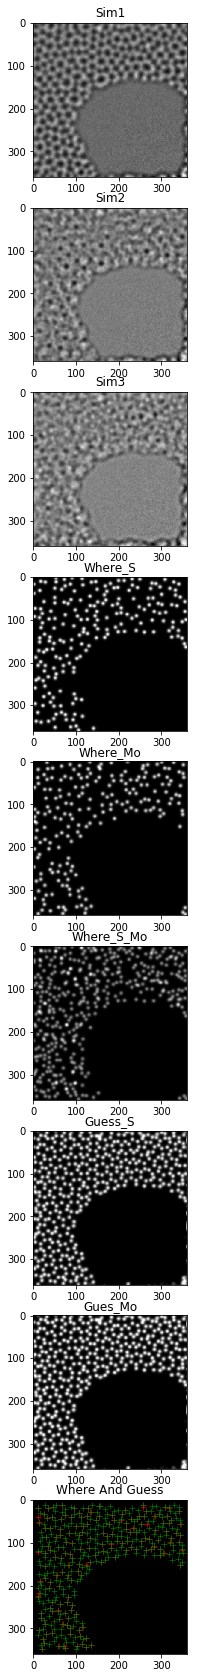

In [43]:
prec, rec, pred_pos, lbl_pos = evaluate_result(predictions[0],label[0])
image_number = 0 #Virker ikke rigtigt som jeg vil have den til, siden den skal tage evaluate_result med


fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9,1,figsize=(6,30))
sim1 = ax1.imshow(image[image_number,:,:,0].T,cmap='gray')
sim2 = ax2.imshow(image[image_number,:,:,1].T,cmap='gray')
sim3 = ax3.imshow(image[image_number,:,:,2].T,cmap='gray')
ax1.set_title('Sim1')
ax2.set_title('Sim2')
ax3.set_title('Sim3')

Where_S = ax4.imshow(label[image_number,:,:,0].T,cmap='gray')
Where_Mo = ax5.imshow(label[image_number,:,:,1].T,cmap='gray')
ax4.set_title('Where_S')
ax5.set_title('Where_Mo')

Where_S_Mo = ax6.imshow(label[image_number,:,:,1]+label[0,:,:,0].T,cmap='gray')
ax6.set_title('Where_S_Mo')

Guess_S = ax7.imshow(predictions[image_number,:,:,0].T,cmap='gray')
Guess_Mo = ax8.imshow(predictions[image_number,:,:,1].T,cmap='gray')
ax7.set_title('Guess_S')
ax8.set_title('Gues_Mo')


ax9.imshow(np.zeros_like(image)[image_number,:,:,0].T, cmap='gray')
ax9.scatter(lbl_pos[:,0], lbl_pos[:,1], c='r', marker='+', linewidth=.6)
ax9.scatter(pred_pos[:,0], pred_pos[:,1], c='g', marker='+', linewidth=.6)
ax9.set_title('Where And Guess')
#ax1.axis('off')
#ax2.axis('off')
#ax3.axis('off')
#ax4.axis('off')
plt.savefig("hey")

In [14]:
prec

0.059593023255813955

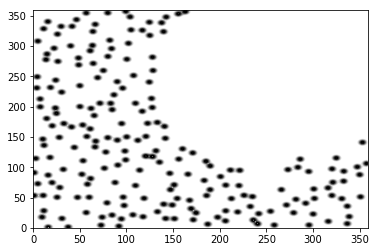

In [26]:
plt.contour(label[0,:,:,0], cmap='Greys')

In [29]:
label[0,:,:,:].shape

(360, 360, 3)

In [40]:
plt.savefig("hey")

<Figure size 432x288 with 0 Axes>

In [31]:
help(plt.savefig)

Help on function savefig in module matplotlib.pyplot:

savefig(*args, **kwargs)
    Save the current figure.
    
    Call signature::
    
      savefig(fname, dpi=None, facecolor='w', edgecolor='w',
              orientation='portrait', papertype=None, format=None,
              transparent=False, bbox_inches=None, pad_inches=0.1,
              frameon=None)
    
    The output formats available depend on the backend being used.
    
    Parameters
    ----------
    
    fname : str or file-like object
        A string containing a path to a filename, or a Python
        file-like object, or possibly some backend-dependent object
        such as :class:`~matplotlib.backends.backend_pdf.PdfPages`.
    
        If *format* is *None* and *fname* is a string, the output
        format is deduced from the extension of the filename. If
        the filename has no extension, the value of the rc parameter
        ``savefig.format`` is used.
    
        If *fname* is not a string, remember 

In [36]:
lbl_pos[:,0].shape

(168,)

In [38]:
predictions.shape

(1, 360, 360, 3)